In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [37]:


train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')


In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as k
from keras.utils import to_categorical
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.layers import BatchNormalization

from sklearn.model_selection import train_test_split


In [39]:
y_label= train["label"]
train = train.drop(['label'] , axis=1)

Text(0.5, 1.0, 'Number of digit classes')

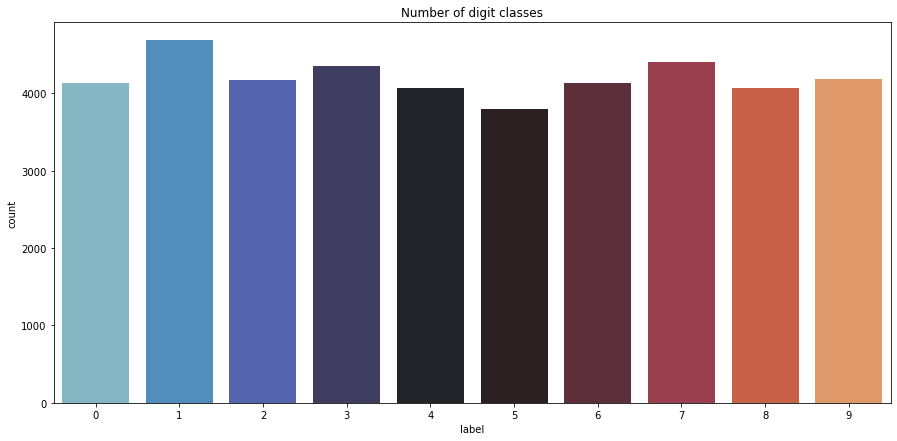

In [40]:
plt.figure(figsize=(15,7))
g = sns.countplot(y_label, palette="icefire")
plt.title("Number of digit classes")


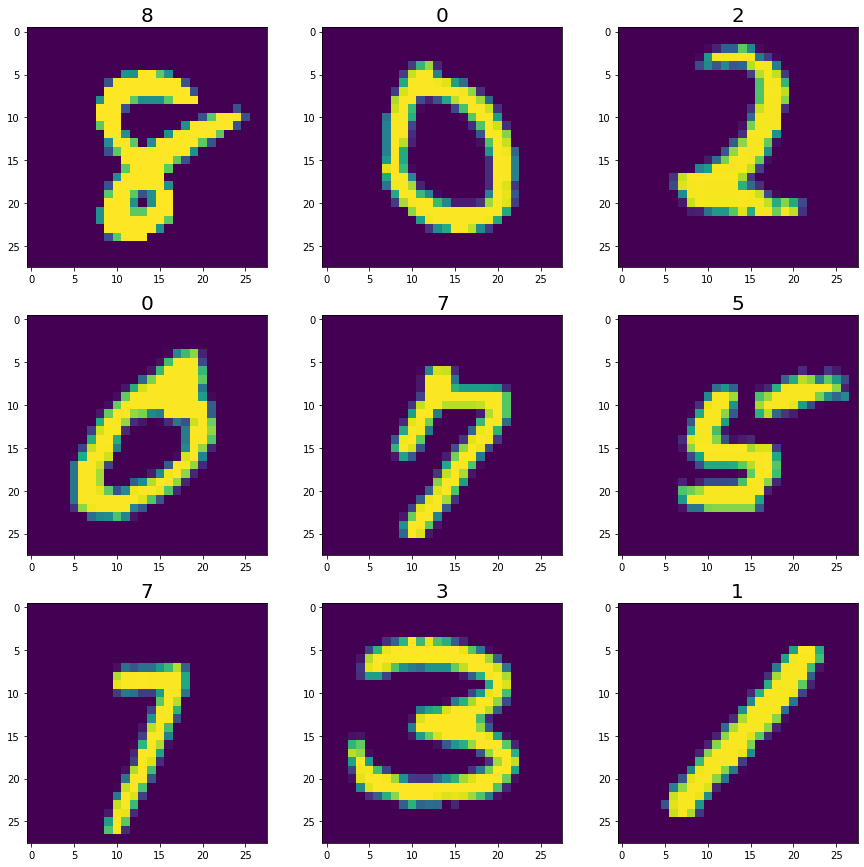

In [41]:
fig,ax =plt.subplots(3,3,figsize=(15,15))

for i in range(3):
    for j in range(3):
        s=np.random.randint(0,len(train))
        val = train.iloc[s,0:].values
        img =val.reshape(28,28)
        ax[i][j].imshow(img)
        ax[i][j].set_title(y_label[s],fontsize=20)

In [42]:
y_label = to_categorical(y_label,num_classes=10)
y_label

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [43]:
train = train/255.0
test = test/255.0

In [44]:
print(test.shape)
print(train.shape)

(28000, 784)
(42000, 784)


In [45]:
test = test.values.reshape(-1,28,28,1)
train = train.values.reshape(-1,28,28,1)
print(test.shape)
print(train.shape)


(28000, 28, 28, 1)
(42000, 28, 28, 1)


In [46]:
#create model
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size=(5,5), padding ='Same' , activation = 'relu' , input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 8, kernel_size=(5,5), padding ='Same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 16, kernel_size=(3,3), padding ='Same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 16, kernel_size=(3,3), padding ='Same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(BatchNormalization())




model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.50))
model.add(BatchNormalization())
model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 8)         208       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 8)         32        
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 8)         1608      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 8)         32        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)       

In [47]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [48]:
x_train, x_test, y_train, y_test = train_test_split(train,y_label, test_size=0.20, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(33600, 28, 28, 1)
(33600, 10)
(8400, 28, 28, 1)
(8400, 10)


In [49]:
batch_size=250
epochs = 25

gen = ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=5, width_shift_range=0.1,
    height_shift_range=0.1, brightness_range=None, shear_range=0.1, zoom_range=0.1,
    channel_shift_range=0.1, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)

gen.fit(train)

In [50]:
fitting = model.fit_generator(gen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/25
134/134 [==============================] - 40s 297ms/step - loss: 0.5431 - accuracy: 0.8293 - val_loss: 2.7388 - val_accuracy: 0.1156
Epoch 2/25
134/134 [==============================] - 39s 293ms/step - loss: 0.1752 - accuracy: 0.9478 - val_loss: 0.9641 - val_accuracy: 0.6843
Epoch 3/25
134/134 [==============================] - 40s 302ms/step - loss: 0.1228 - accuracy: 0.9639 - val_loss: 0.2149 - val_accuracy: 0.9345
Epoch 4/25
134/134 [==============================] - 41s 306ms/step - loss: 0.0983 - accuracy: 0.9700 - val_loss: 0.0502 - val_accuracy: 0.9858
Epoch 5/25
134/134 [==============================] - 40s 296ms/step - loss: 0.0840 - accuracy: 0.9747 - val_loss: 0.0414 - val_accuracy: 0.9887
Epoch 6/25
134/134 [==============================] - 41s 304ms/step - loss: 0.0766 - accuracy: 0.9775 - val_loss: 0.0387 - val_accuracy: 0.9889
Epoch 7/25
134/134 [==============================] - 40s 301ms/step - loss: 0.0703 - accuracy: 0.9793 - val_loss: 0.0440 - val_ac

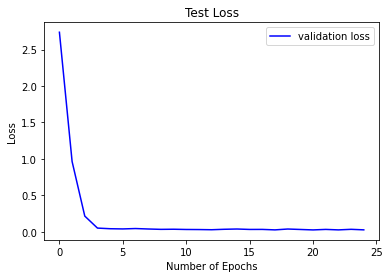

In [51]:
plt.plot(fitting.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [52]:
y_pred = model.predict(test)
y = np.argmax(y_pred, axis = 1)

In [53]:
sub = pd.read_csv('../input/digit-recognizer/sample_submission.csv')
sub.shape

(28000, 2)

In [54]:
sub['Label'] = y

In [61]:
sub['Label'].value_counts()
sub.to_csv('submission.csv', index=False)
